## Oakland Athletics: A Sentiment Analysis of MLB Performance

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install pandas
!pip install matplotlib
!pip install lxml
!pip install nltk
!pip install wordcloud

In [12]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import lxml

import os
import re
import numpy as np
import string
import glob
import nltk
from wordcloud import WordCloud
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation

sw = stopwords.words("english")

##### The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

In [3]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)
    return df

In [4]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major l...
1,A’s Acquire Yacksel Rios,Nick Deeds,"June 18, 2023",6:56 PM: As noted by Justin Toscano of the Atl...
2,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,"June 18, 2023",The Red Sox are looking to acquire an infielde...
3,A's To Stay In Oakland Through 2024 Season,Nick Deeds,"June 17, 2023",While the Athletics seem more likely than ever...
4,"A’s Select Tyler Wade, Place Kevin Smith On 10...",Mark Polishuk,"June 17, 2023",The Athletics placed infielder Kevin Smith on ...


In [5]:
# Change the Data column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(df)

1030

## Cleaning the Data

In [9]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [10]:
df['Content'].apply

<bound method Series.apply of 0       The Orioles have announced that former major l...
1       6:56 PM: As noted by Justin Toscano of the Atl...
2       The Red Sox are looking to acquire an infielde...
3       While the Athletics seem more likely than ever...
4       The Athletics placed infielder Kevin Smith on ...
                              ...                        
1025                                                     
1026                                                     
1027                                                     
1028                                                     
1029                                                     
Name: Content, Length: 1030, dtype: object>

In [11]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
df['impurity'] = df['Content'].apply(impurity, min_len=10)

# get the top 3 records
df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
111,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
944,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
531,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


##### The steps above displays the highest impurity levels for the Athletics' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

## Character Normalization & Tokenization

In [13]:
# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
df["Contents_Normalized"] = df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ..."
1,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...","[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad..."
2,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...","[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ..."
3,While the Athletics seem more likely than ever to relocate to Las Vegas after Nevada’s governor ...,"[athlet, seem, like, ever, reloc, la, vega, nevada, governor, sign, bill, provid, mm, public, fu..."
4,"The Athletics placed infielder Kevin Smith on the 10-day injured list due to a back strain, with...","[athlet, place, infield, kevin, smith, day, injur, list, due, back, strain, placement, retroact,..."


In [14]:
df['length'] = df['Contents_Normalized'].str.len()
df.head()

,Title,Author,Date,Content,impurity,Contents_Normalized,length
0,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173
1,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",0.0,"[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad...",206
2,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...",0.0,"[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ...",84
3,A's To Stay In Oakland Through 2024 Season,Nick Deeds,2023-06-17,While the Athletics seem more likely than ever to relocate to Las Vegas after Nevada’s governor ...,0.0,"[athlet, seem, like, ever, reloc, la, vega, nevada, governor, sign, bill, provid, mm, public, fu...",102
4,"A’s Select Tyler Wade, Place Kevin Smith On 10-Day IL",Mark Polishuk,2023-06-17,"The Athletics placed infielder Kevin Smith on the 10-day injured list due to a back strain, with...",0.0,"[athlet, place, infield, kevin, smith, day, injur, list, due, back, strain, placement, retroact,...",127


<Axes: >

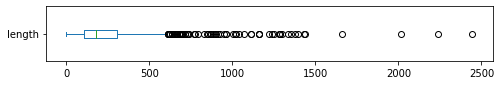

In [15]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

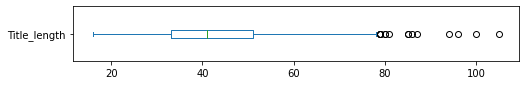

In [16]:
df['Title_length'] = df['Title'].str.len()
df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

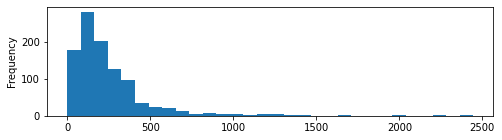

In [17]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='Date'>

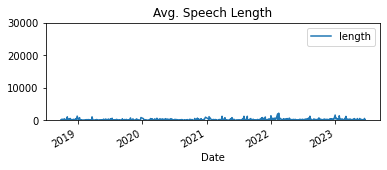

In [18]:
df.groupby('Date').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

##### Import data on the Oakland Athletics from baseball-reference.com.

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [20]:
# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv


In [21]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


In [22]:
athletics_df= athletics_df[athletics_df['Year'] > 2004]
athletics_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum
5,2018,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1573616.0,19427.0,13th of 15,"$69,883,333",97,97,Oakland-Alameda County Coliseum
6,2017,Oakland Athletics,AL West,75,87,5,NaN,1475721.0,18219.0,14th of 15,"$51,560,000",95,95,Oakland-Alameda County Coliseum
7,2016,Oakland Athletics,AL West,69,93,5,NaN,1521506.0,18784.0,14th of 15,"$54,969,067",97,96,Oakland-Alameda County Coliseum
8,2015,Oakland Athletics,AL West,68,94,5,NaN,1768175.0,21829.0,12th of 15,"$64,016,001",97,97,O.co Coliseum
9,2014,Oakland Athletics,AL West,88,74,2,Lost ALWC (1-0),2003628.0,24736.0,10th of 15,"$89,160,900",97,98,O.co Coliseum


In [23]:
#remove the dollar sign from Est. Payroll column
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\$':''}, regex = True)
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\,':''}, regex = True)
athletics_df['Attendance'] = athletics_df['Attendance'].replace({'\,':''}, regex = True)
athletics_df['Attend/G'] = athletics_df['Attend/G'].replace({'\,':''}, regex = True)
athletics_df['Stadium'] = athletics_df['Stadium'].replace({'\,':''}, regex = True)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,55,5,NaN,368146.0,9688.0,15th of 15,51230000,94,92,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334,95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834,95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333,94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833,93,94,Oakland-Alameda County Coliseum


In [24]:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].astype(float)
athletics_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

In [25]:
athletics_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000
mean,2014.000000,76.157895,75.789474,2.894737,1.518666e+06,19041.388889,6.754905e+07,96.105263,96.105263
std,5.627314,20.456629,17.491518,1.523692,4.682565e+05,5114.775012,1.597226e+07,1.940640,2.157538
min,2005.000000,19.000000,24.000000,1.000000,3.681460e+05,8660.000000,4.796713e+07,93.000000,92.000000
25%,2009.500000,71.500000,67.000000,2.000000,1.432724e+06,17688.000000,5.519741e+07,94.500000,94.500000
50%,2014.000000,76.000000,76.000000,3.000000,1.619436e+06,19993.000000,6.484308e+07,97.000000,96.000000
75%,2018.500000,90.500000,87.000000,4.500000,1.799020e+06,22210.000000,7.462514e+07,97.000000,98.000000
max,2023.000000,97.000000,102.000000,5.000000,2.109118e+06,26038.000000,1.029358e+08,100.000000,100.000000


Text(0.5, 1.0, 'Attendance of Oakland Athletics over the Years')

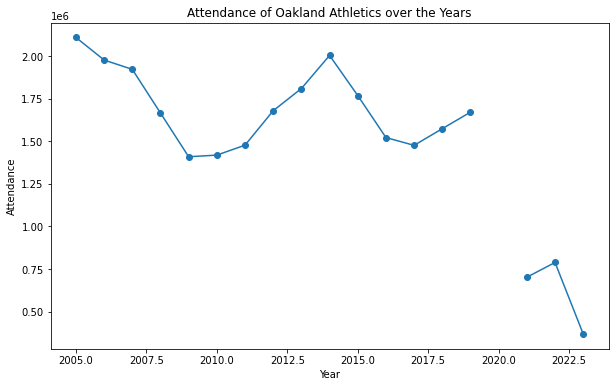

In [26]:
# Plot data
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(athletics_df['Year'], athletics_df['Attendance'], marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Oakland Athletics over the Years')

Text(0.5, 1.0, 'Wins of Oakland Athletics over the Years')

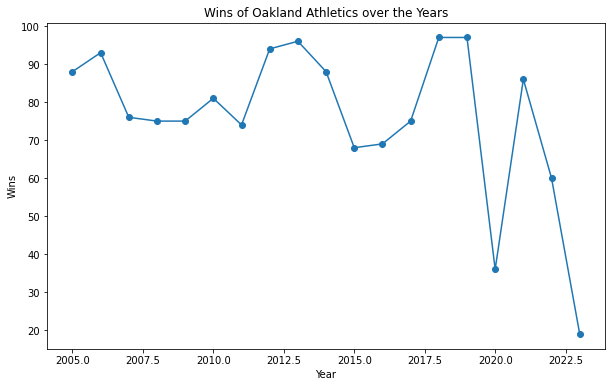

In [27]:
# Plotting Wins over the years
plt.figure(figsize=(10, 6))
plt.plot(athletics_df['Year'], athletics_df['W'], marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins of Oakland Athletics over the Years')

Text(0.5, 1.0, 'Payroll of Oakland Athletics over the Years')

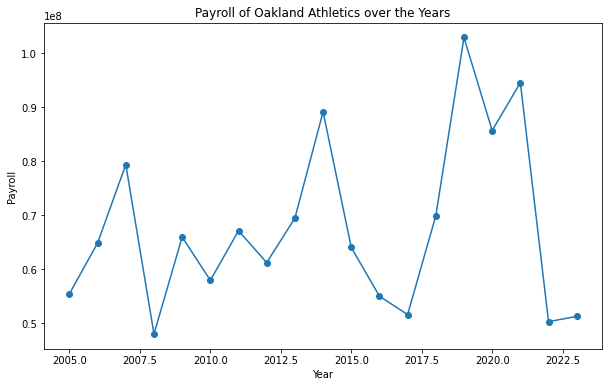

In [28]:
# Plotting Payroll over the years
plt.figure(figsize=(10, 6))
plt.plot(athletics_df['Year'], athletics_df['Est. Payroll'], marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Oakland Athletics over the Years')

                  Year         W         L    Finish  Attendance  Attend/G  \
Year          1.000000 -0.461594 -0.272585  0.356362   -0.739316 -0.740579   
W            -0.461594  1.000000  0.292504 -0.498125    0.702923  0.602977   
L            -0.272585  0.292504  1.000000  0.565745    0.085816 -0.029819   
Finish        0.356362 -0.498125  0.565745  1.000000   -0.541928 -0.535614   
Attendance   -0.739316  0.702923  0.085816 -0.541928    1.000000  0.983150   
Attend/G     -0.740579  0.602977 -0.029819 -0.535614    0.983150  1.000000   
Est. Payroll  0.214157  0.281505 -0.380622 -0.439569    0.160458  0.123188   
PPF          -0.479714  0.252063  0.252121 -0.070948    0.289479  0.288072   
BPF          -0.516398  0.396448  0.056171 -0.359041    0.512159  0.487661   

              Est. Payroll       PPF       BPF  
Year              0.214157 -0.479714 -0.516398  
W                 0.281505  0.252063  0.396448  
L                -0.380622  0.252121  0.056171  
Finish           -0.439

Text(0.5, 1.0, 'Correlation Matrix')

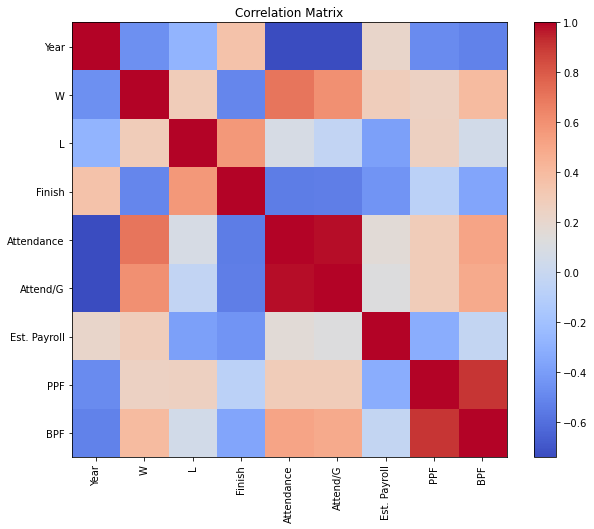

In [14]:
# Correlation matrix
correlation = athletics_df.corr()
print(correlation)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title('Correlation Matrix')

## Descriptive Stats of Data

In [29]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common tokens. 
        Return a list with the number of tokens, number of unique tokens, lexical diversity, 
        and number of characters. 
    
    """
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        c = Counter(tokens)
        top_five = c.most_common(5)
        top_five_df = pd.DataFrame(top_five, columns= ['Token', 'Count'])
        print("\nFive Most Common Tokens: \n\n", top_five_df)

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [30]:
# Clean the data
punctuation = set(punctuation)

athletics_clean_df = athletics_df.copy()
athletics_clean_df = athletics_clean_df.dropna()

stop_words = stopwords.words('english')
athletics_nostop = athletics_clean_df.apply(lambda x: [item for item in x if item not in stop_words])
athletics_clean_df = athletics_nostop

In [31]:
print("\nOakland Athletics Results:\n")
print(descriptive_stats(athletics_clean_df))


Oakland Athletics Results:

There are 6 tokens in the data.
There are 14 unique tokens in the data.
There are 71 characters in the data.
The lexical diversity is 2.333 in the data.

Five Most Common Tokens: 

   Token  Count
0  Year      1
1    Tm      1
2    Lg      1
3     W      1
4     L      1
[6, 14, 2.3333333333333335, 71]
